## Initial setup
##### This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.

In [1]:

'''
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Load the results

In [4]:
from ema_workbench import load_results

#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-07_EET_allV3.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-25-LHS.tar.gz')
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_2020-Jun-29-SOBOL.tar.gz')



In [5]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [6]:
experiments.head()

,annualCpi,annualInflation,capacityFactorChangeBrownCoal,capacityFactorChangeWater,consumption,energyEfficiency,generationRolloutPeriod,generatorRetirement,includePublicallyAnnouncedGen,learningCurve,...,priceChangePercentageWind,rooftopPV,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,technologicalImprovement,wholesaleTariffContribution,scenario,policy,model
0,0.018789,0.013867,0.0,4.0,Slow change,Step change,0.0,4.0,1.0,0.003467,...,-22.0,residential,secondary,10.407324,Step change,0.072559,28.0,0,None,Gr4sp
1,0.031992,0.013867,0.0,4.0,Slow change,Step change,0.0,4.0,1.0,0.003467,...,-22.0,residential,secondary,10.407324,Step change,0.072559,28.0,1,None,Gr4sp
2,0.018789,0.048008,0.0,4.0,Slow change,Step change,0.0,4.0,1.0,0.003467,...,-22.0,residential,secondary,10.407324,Step change,0.072559,28.0,2,None,Gr4sp
3,0.018789,0.013867,1.0,4.0,Slow change,Step change,0.0,4.0,1.0,0.003467,...,-22.0,residential,secondary,10.407324,Step change,0.072559,28.0,3,None,Gr4sp
4,0.018789,0.013867,0.0,2.0,Slow change,Step change,0.0,4.0,1.0,0.003467,...,-22.0,residential,secondary,10.407324,Step change,0.072559,28.0,4,None,Gr4sp


In [28]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 'numConsumersYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 'offSpotProductionYear', 
                    'renewableContributionYear', 'rooftopPVProductionYear', 'coalProductionYear', 
                    'waterProductionYear', 'windProductionYear', 'gasProductionYear', 'solarProductionYear', 
                    'BatteryProductionYear', 'numActorsYear']

# 21 levers selected after EET
levers = ['annualCpi', 'annualInflation', 'capacityFactorChangeBrownCoal',
       'capacityFactorChangeWater', 'consumption', 'energyEfficiency',
       'generationRolloutPeriod', 'generatorRetirement',
       'includePublicallyAnnouncedGen', 'learningCurve',
       'nonScheduleGenSpotMarket', 'nonScheduleMinCapMarketGen',
       'priceChangePercentageBrownCoal', 'priceChangePercentageWater',
       'priceChangePercentageWind', 'rooftopPV', 'semiScheduleGenSpotMarket',
       'semiScheduleMinCapMarketGen', 'solarUptake',
       'technologicalImprovement', 'wholesaleTariffContribution']

#from startYear
startYear = 1998
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')





# Target functions

In [29]:
def target_always_after(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        for j in range( len(exp_run) ):
            if (startYear + j) >= targetYear:
                if above is True:
                    achieved[i] = exp_run[j] >= targetVal
                else:
                    achieved[i] = exp_run[j] < targetVal
                    
                #If the target is not achieved after the TargetYear, then mark experiment as False
                if achieved[i] == False:
                    break
    return achieved

def target_at_year(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        
        idx = targetYear - startYear
        if above is True:
            achieved[i] = exp_run[idx] >= targetVal
        else:
            achieved[i] = exp_run[idx] < targetVal                        
                
    return achieved

# Scenario discovery

## GHG emissions


GHG emissions per household type and total residential area


In [13]:
ooi = 'GHGYear'
data_GHG_household = outcomes[ooi]

In [14]:
""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * outcomes['numConsumersYear']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential"""
data_GHG_total = data_GHG_residential / (1/3)

Truncate experiments and outcomes for a selected policy and a selected outcome over mean in time series

In [15]:
#Subset of levers
#selected_levers = list(['rooftopPV', 'annualCpi','capacityFactorChangeBrownCoal','capacityFactorChangeWater','semiScheduleMinCapMarketGen'])    
selected_levers = levers

"""Overwrite GHG with the data of interest"""
outcomes[ooi] = data_GHG_total

data = outcomes[ooi]


num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

The following section uses PRIM, feature scoring and dimensional stacking to find the cases that represent futures in three main groups: Low Carbon, Just Transition and Resilient Transition.

It uses targets (e.g. cases for which emissions are the lowest at year x) to filter out the cases and find out the corresponding input variables and ranges for the cases to happen.

The first case is on GHG emissions. To find out the targets for exploration, first let's analyse the envelope diagram (see below) showing how the transition may unfold:

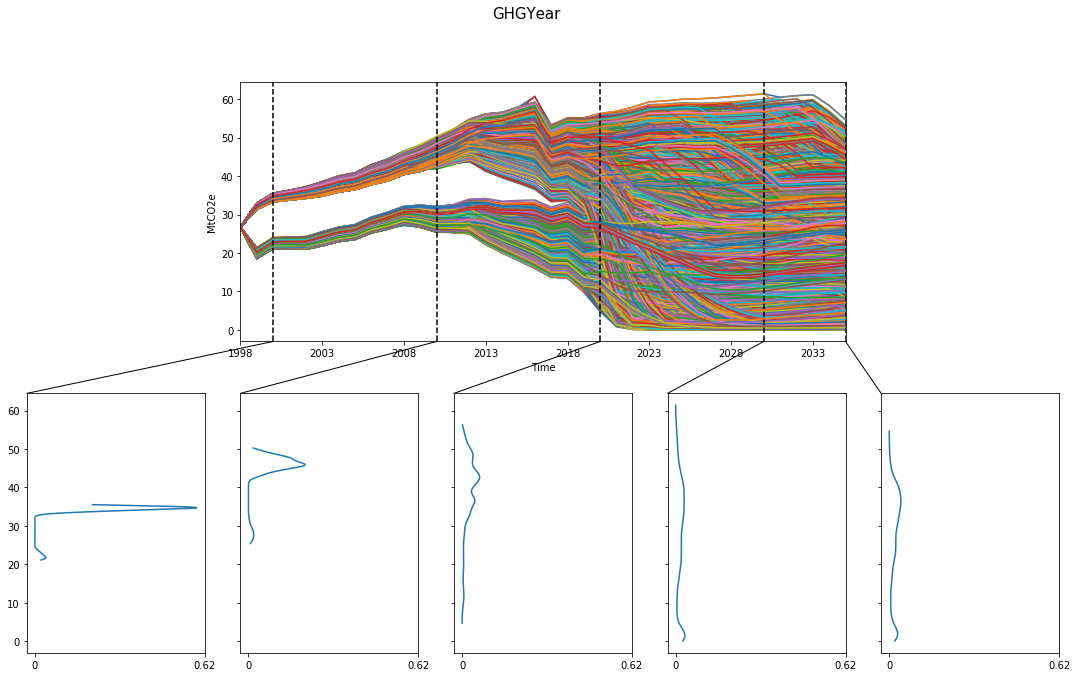

In [16]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes, outcomes_to_show = ooi,
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)



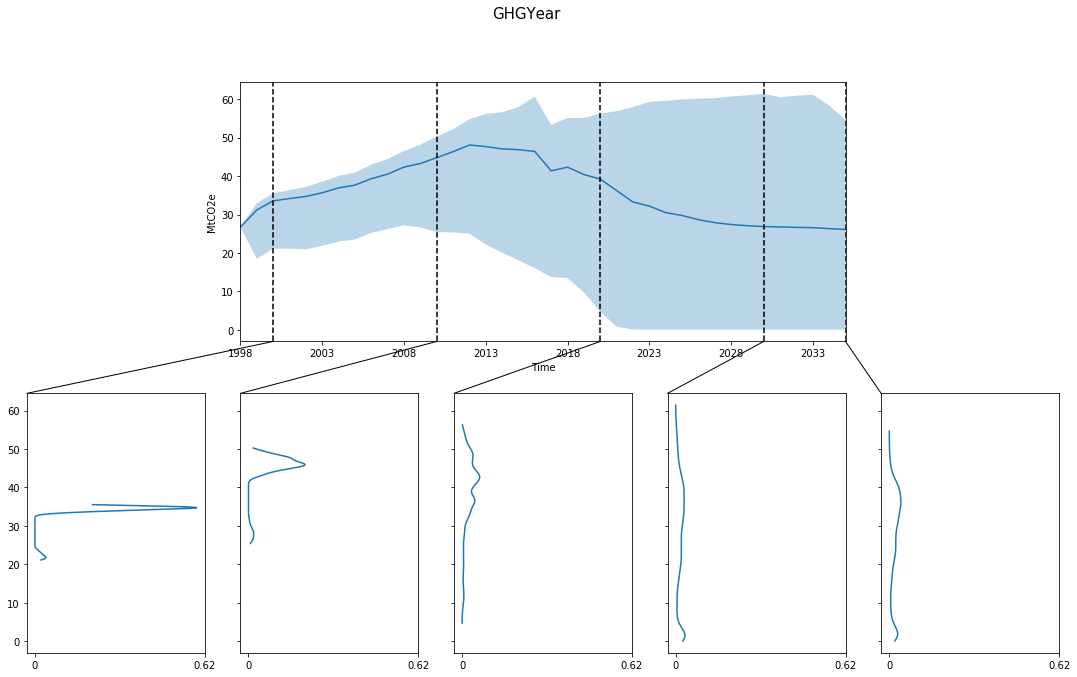

In [17]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes, outcomes_to_show = ooi,
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

As the envelope shows, there are two main groups at the first years of analysis where GHG emissions either increase or decrease. However, as time passes, GHG emissions can vary widely. 
Taking the first year of analysis, year 2020, we can investigate the cases where GHG emissions per year per household fall below 30.89 MtonsCO2-e. This is 20% lower than the emissions in BAU for 2005, which were 38.62 MtCO2-e

In [18]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = (out_avg_ooi < 4.)
y = target_at_year( outcomes, ooi, 2020, 30.89 , False) #False is below target

#Threshold for density
prim_alg = prim.Prim(x, y, threshold=0.5)
box1 = prim_alg.find_box()



[MainProcess/INFO] 47104 points remaining, containing 6341 cases of interest
[MainProcess/INFO] mean: 0.8522681653954235, mass: 0.05288298233695652, coverage: 0.33480523576722915, density: 0.8522681653954235 restricted_dimensions: 9


In [19]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage     0.54944
density     0.572367
id                30
mass        0.129225
mean        0.572367
res_dim            4
Name: 30, dtype: object

                               box 30                                     
                                  min   max                      qp values
priceChangePercentageWater      -30.0 -11.5                    [-1.0, 0.0]
capacityFactorChangeBrownCoal   -10.0   8.5  [-1.0, 9.697677048991218e-08]
priceChangePercentageBrownCoal    0.5  30.0                    [0.0, -1.0]
generationRolloutPeriod           0.5  10.0  [0.0013461469894422181, -1.0]



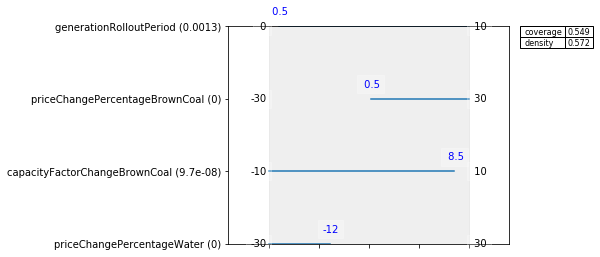

In [20]:
#%matplotlib inline
box_1 = box1.inspect(30)
box_1 = box1.inspect(30, style='graph')


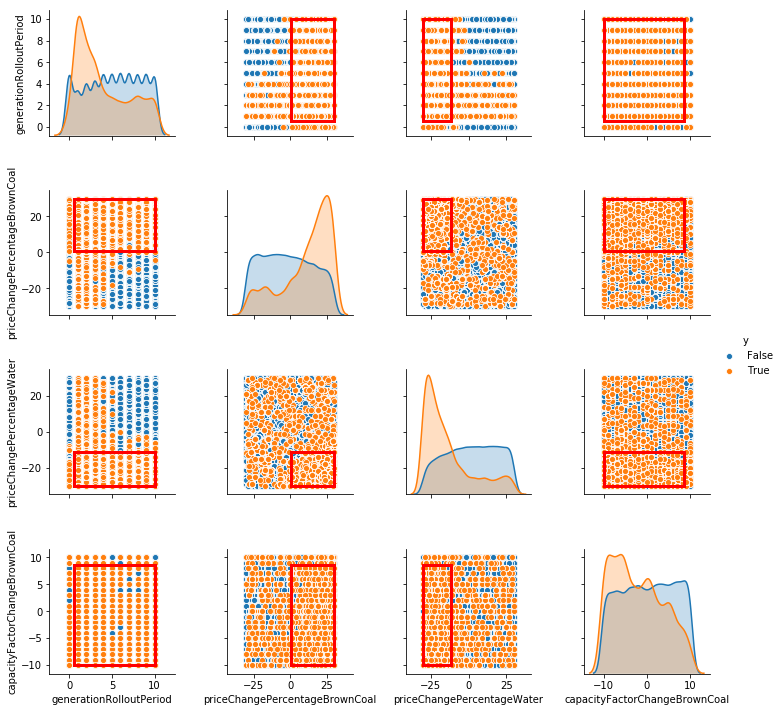

In [13]:
box1.select(30)
fig = box1.show_pairs_scatter(30)

plt.show()


### Feature Scoring

In [14]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)



,1
0,
priceChangePercentageWater,0.210134
priceChangePercentageBrownCoal,0.162342
generationRolloutPeriod,0.123854
semiScheduleGenSpotMarket,0.082816
capacityFactorChangeWater,0.047843
capacityFactorChangeBrownCoal,0.045993
nonScheduleGenSpotMarket,0.038794
technologicalImprovement,0.021787
annualCpi,0.021222


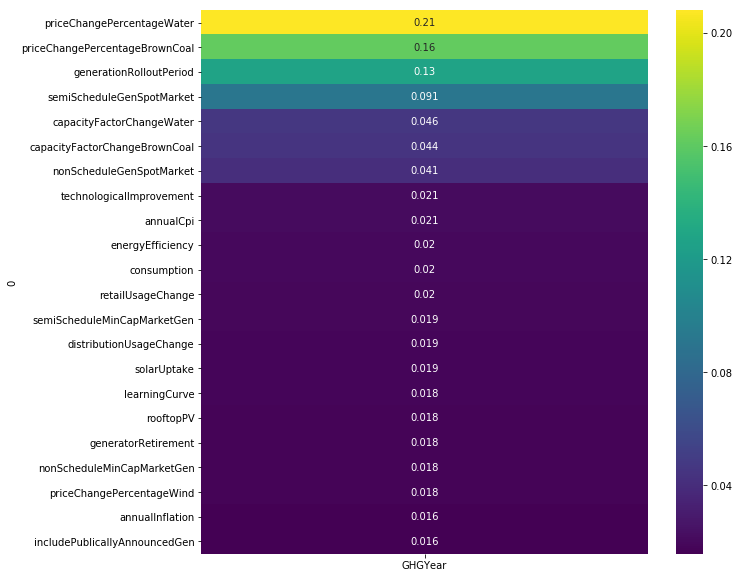

In [21]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['GHGYear'] = y

fig, ax = plt.subplots(figsize=(10,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional Stacking


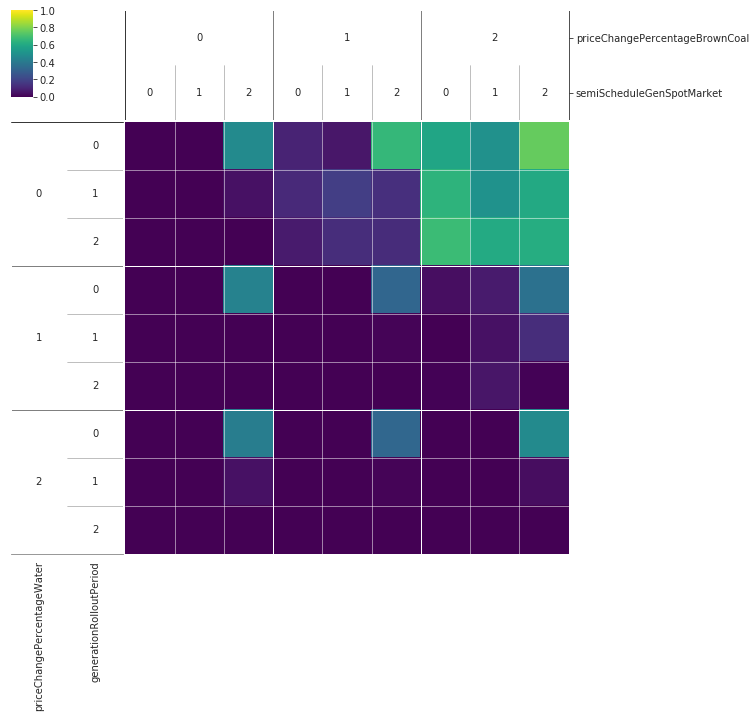

In [28]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



## Wholesale Price

In [30]:
# Subset Sobol levers
#selected_levers = list(['rooftopPV','annualCpi', 'generationRolloutPeriod', 'generatorRetirement','capacityFactorChangeBrownCoal','semiScheduleMinCapMarketGen'])    

selected_levers = levers
ooi = 'wholesalePriceYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

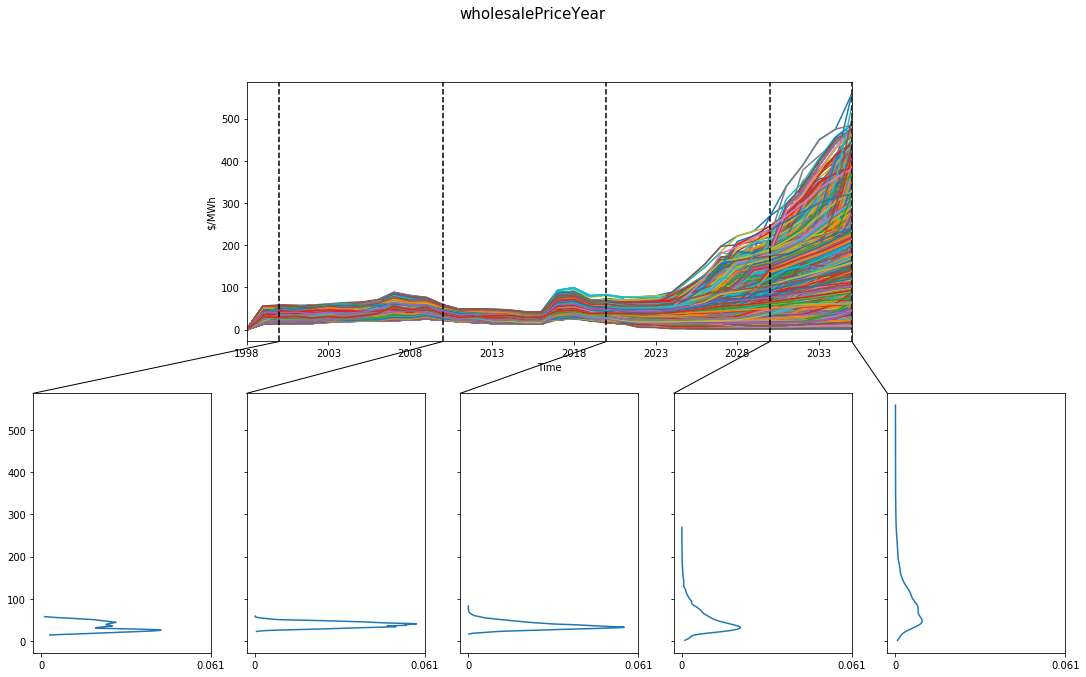

In [31]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

Wholesale prices: 20-25% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 38.44-36.03 (20-25%)

In [47]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes, ooi, 2025, 36.03, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.8, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 47104 points remaining, containing 34905 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.18720278532608695, coverage: 0.25262856324308836, density: 1.0 restricted_dimensions: 8


In [48]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

We can see that the targets are __not ambitious enough__, and is sufficient to __delay slightly the rollout of renewables__, and **avoid the earliest retirement of brown coal**

coverage    0.719009
density     0.968211
id                 3
mass        0.550293
mean        0.968211
res_dim            3
Name: 3, dtype: object

                          box 3                                       
                            min   max                        qp values
semiScheduleGenSpotMarket   8.5  10.0                      [0.0, -1.0]
generationRolloutPeriod     0.5  10.0  [1.8263328052394514e-223, -1.0]
generatorRetirement        -4.5   5.0    [1.584734828971388e-56, -1.0]



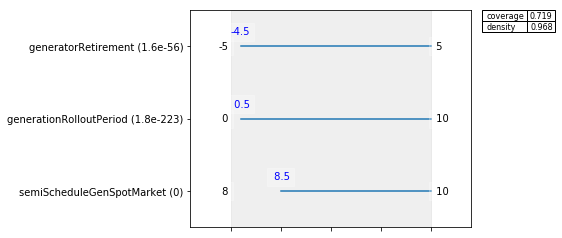

In [49]:
%matplotlib inline
box_1 = box1.inspect(3)
box_1 = box1.inspect(3, style='graph')

### A more ambitious target
Wholesale prices: 50% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 24.02 (50%)

In [50]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes, ooi, 2025, 24.02, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.45, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 47104 points remaining, containing 14562 cases of interest
[MainProcess/INFO] mean: 0.9985294117647059, mass: 0.057744565217391304, coverage: 0.18651284164263152, density: 0.9985294117647059 restricted_dimensions: 7


In [51]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.711303
density     0.780499
id                13
mass        0.281738
mean        0.780499
res_dim            4
Name: 13, dtype: object

                               box 13                                      
                                  min   max                       qp values
priceChangePercentageBrownCoal  -30.0   0.5                     [-1.0, 0.0]
semiScheduleGenSpotMarket         8.5  10.0                     [0.0, -1.0]
generationRolloutPeriod           0.5  10.0  [5.2400717144779496e-58, -1.0]
generatorRetirement              -4.5   5.0   [3.543466993595722e-21, -1.0]



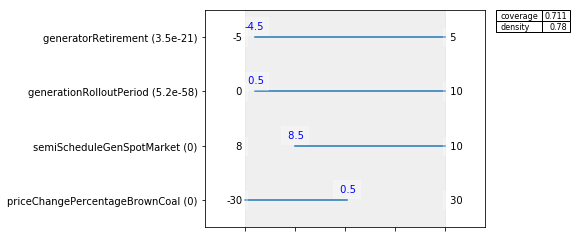

In [52]:
%matplotlib inline
box_1 = box1.inspect(13)
box_1 = box1.inspect(13, style='graph')


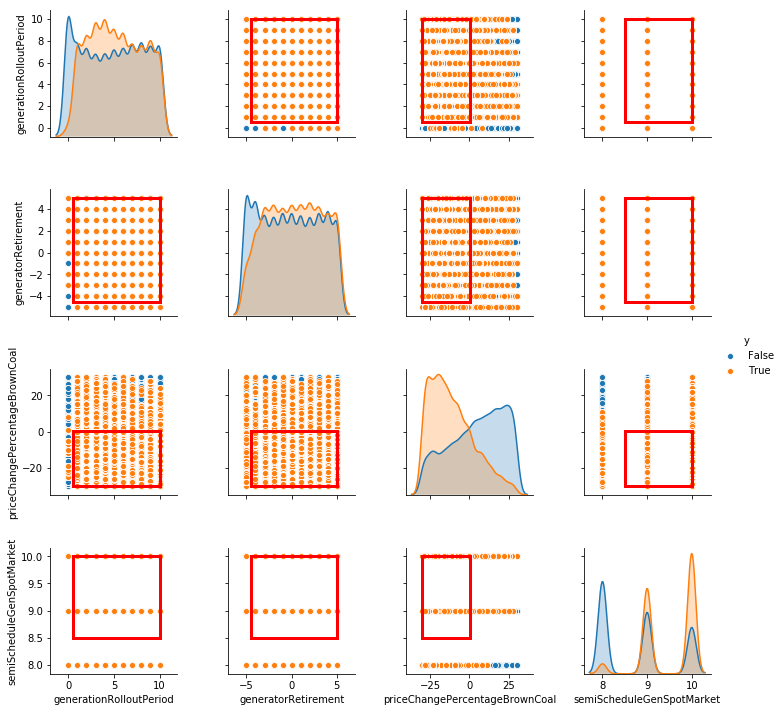

In [53]:
box1.select(13)
fig = box1.show_pairs_scatter(13)

plt.show()

### Feature Scoring

In [63]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)


,1
0,
semiScheduleGenSpotMarket,0.257838
priceChangePercentageBrownCoal,0.239340
annualInflation,0.062361
includePublicallyAnnouncedGen,0.061887
generationRolloutPeriod,0.060199
consumption,0.033144
capacityFactorChangeBrownCoal,0.031965
generatorRetirement,0.029641
priceChangePercentageWater,0.019003


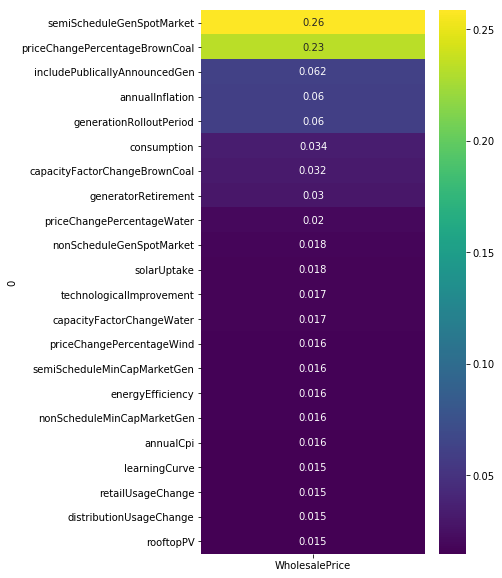

In [61]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['WholesalePrice'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional stacking

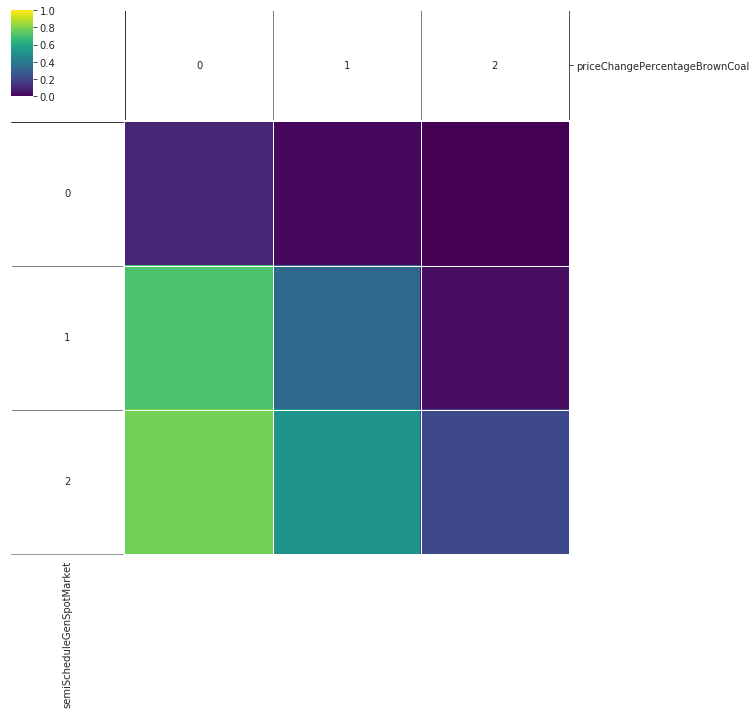

In [65]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 1, nbins=3)
plt.show()



## Tariffs

In [21]:
# Subset Sool levers
selected_levers = list(['consumption','rooftopPV','annualInflation','priceChangePercentageBrownCoal',
                        'priceChangePercentageWind','priceChangePercentageWater',
                        'capacityFactorChangeWater','retailUsageChange'])    

#selected_levers = levers
ooi = 'tariffsYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

: 20-25% by 2025 on 2017. tariffs in 2017: ~21 c/KWh

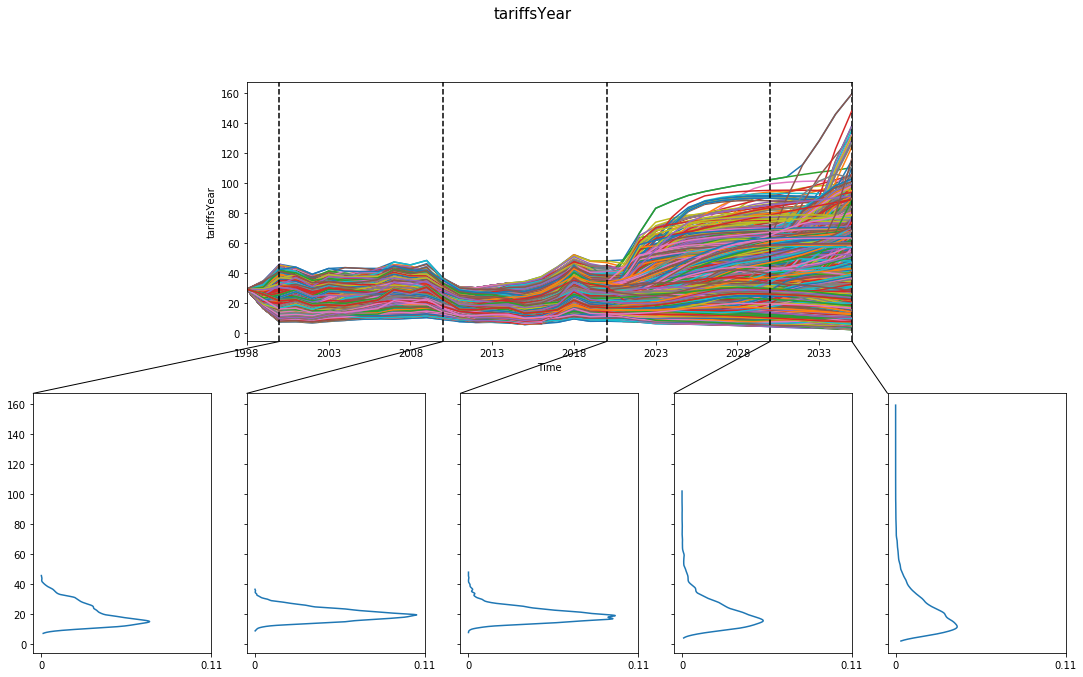

In [22]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [23]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 20

y = target_at_year( outcomes, ooi, 2035, 20, True) #False is below target

prim_alg = prim.Prim(x, y, threshold=.05, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 47104 points remaining, containing 21698 cases of interest
[MainProcess/INFO] mean: 0.7247023809523809, mass: 0.09986413043478261, coverage: 0.15711125449350172, density: 0.7247023809523809 restricted_dimensions: 8


In [57]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.344682
density     0.700784
id                21
mass        0.265285
mean        0.700784
res_dim            6
Name: 21, dtype: object

                                  box 21             \
                                     min        max   
annualInflation                  0.01002   0.027422   
retailUsageChange              -10.00000   8.500000   
priceChangePercentageWind      -30.00000  27.500000   
priceChangePercentageBrownCoal -30.00000  27.500000   
priceChangePercentageWater     -30.00000  26.500000   
consumption                      0.50000   4.000000   

                                                                 
                                                      qp values  
annualInflation                 [-1.0, 1.0788769102624623e-230]  
retailUsageChange                 [-1.0, 7.281655074973277e-05]  
priceChangePercentageWind          [-1.0, 0.007720381672216528]  
priceChangePercentageBrownCoal      [-1.0, 0.08361484756095415]  
priceChangeP

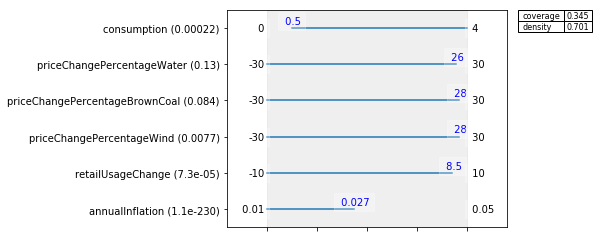

In [59]:
%matplotlib inline
box_1 = box1.inspect(21)
box_1 = box1.inspect(21, style='graph')

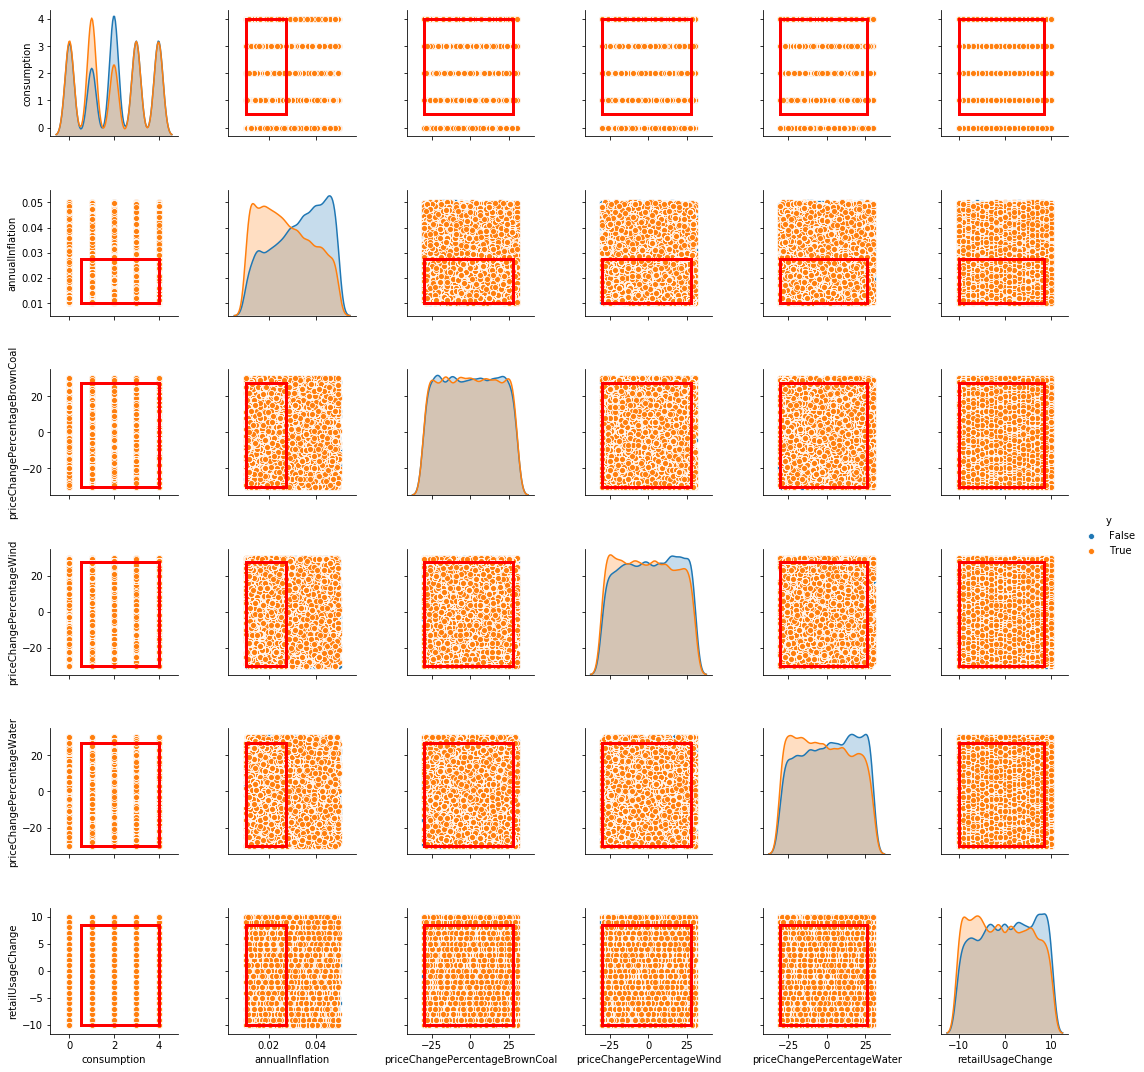

In [60]:
box1.select(21)
fig = box1.show_pairs_scatter(21)
plt.show()

## Primary Spot Production

In [61]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'primarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

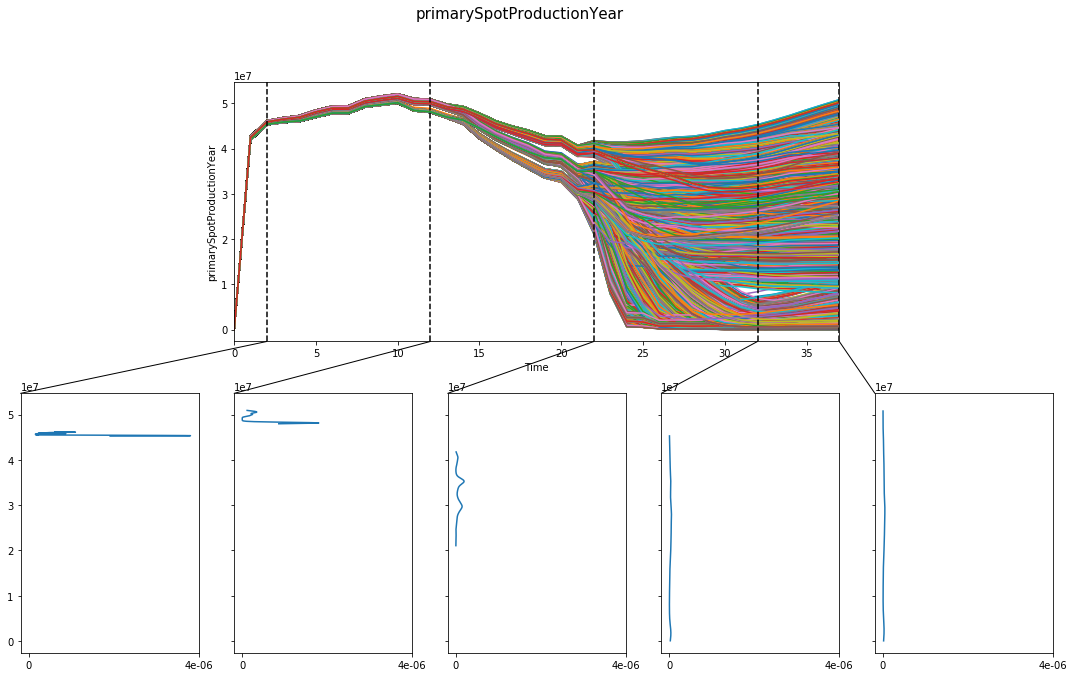

In [62]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [98]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

AssertionError: 

In [97]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.720491
density     0.908497
id                 2
mass        0.250248
mean        0.908497
res_dim            2
Name: 2, dtype: object

                               box 2                        
                                 min        max    qp values
semiScheduleGenSpotMarket  {primary}  {primary}  [0.0, -1.0]
nonScheduleGenSpotMarket   {primary}  {primary}  [0.0, -1.0]



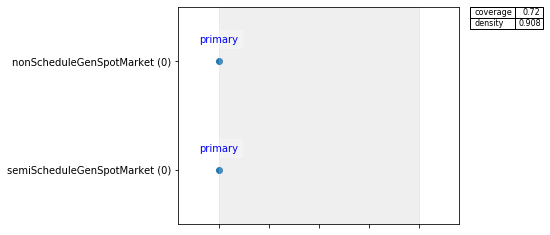

In [204]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [ ]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'secondarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [ ]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'rooftopPVProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [ ]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'secondarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [ ]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'rooftopPVProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

semiScheduleGenSpotMarket ['primary', 'secondary']
nonScheduleGenSpotMarket ['primary', 'secondary']


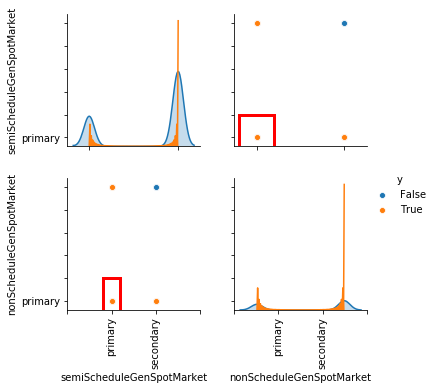

In [205]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [93]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'secondarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

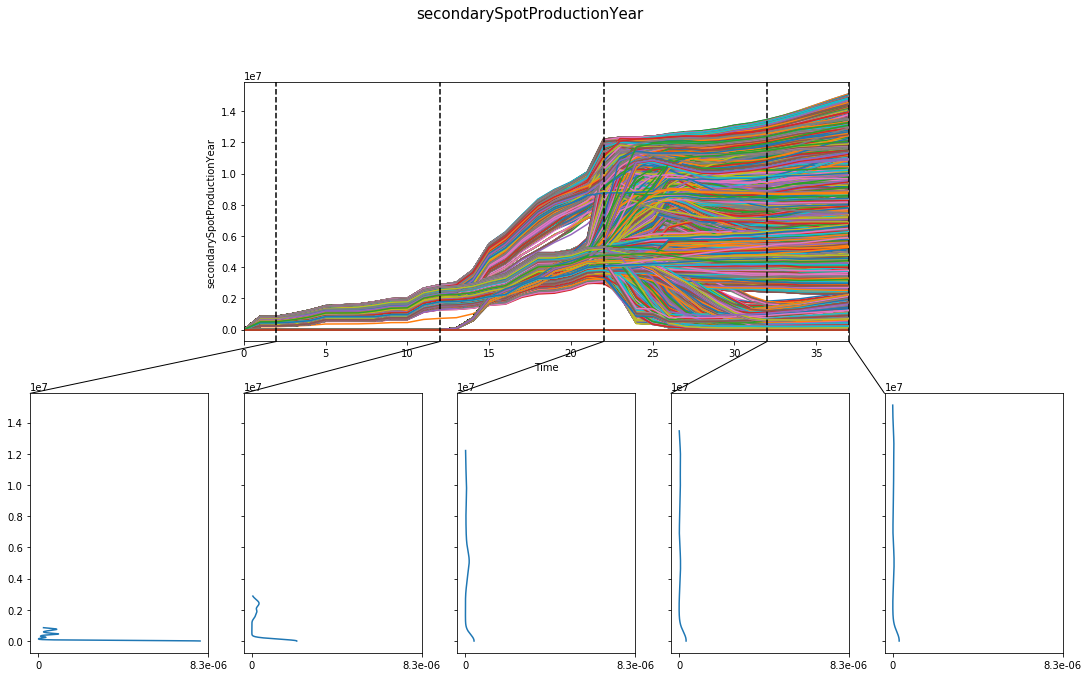

In [94]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [202]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] includePublicallyAnnouncedGen dropped from analysis because only a single category
[MainProcess/INFO] 48300 points remaining, containing 15241 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.16892339544513457, coverage: 0.5353323272751132, density: 1.0 restricted_dimensions: 5


In [203]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.720491
density     0.908497
id                 2
mass        0.250248
mean        0.908497
res_dim            2
Name: 2, dtype: object

                               box 2                        
                                 min        max    qp values
semiScheduleGenSpotMarket  {primary}  {primary}  [0.0, -1.0]
nonScheduleGenSpotMarket   {primary}  {primary}  [0.0, -1.0]



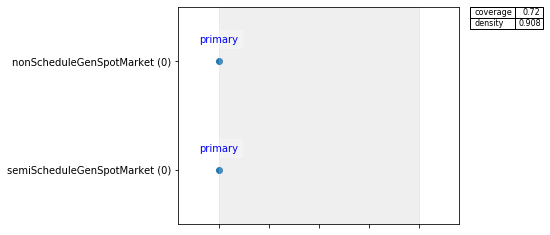

In [204]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

semiScheduleGenSpotMarket ['primary', 'secondary']
nonScheduleGenSpotMarket ['primary', 'secondary']


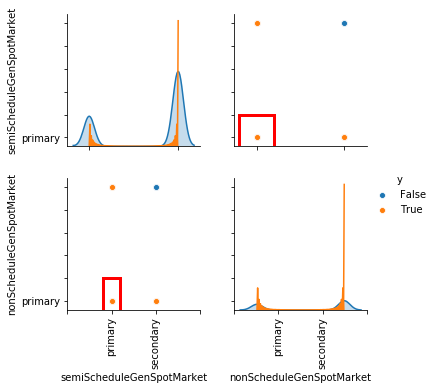

In [205]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [95]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'rooftopPVProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

[MainProcess/WARNING] singular matrix


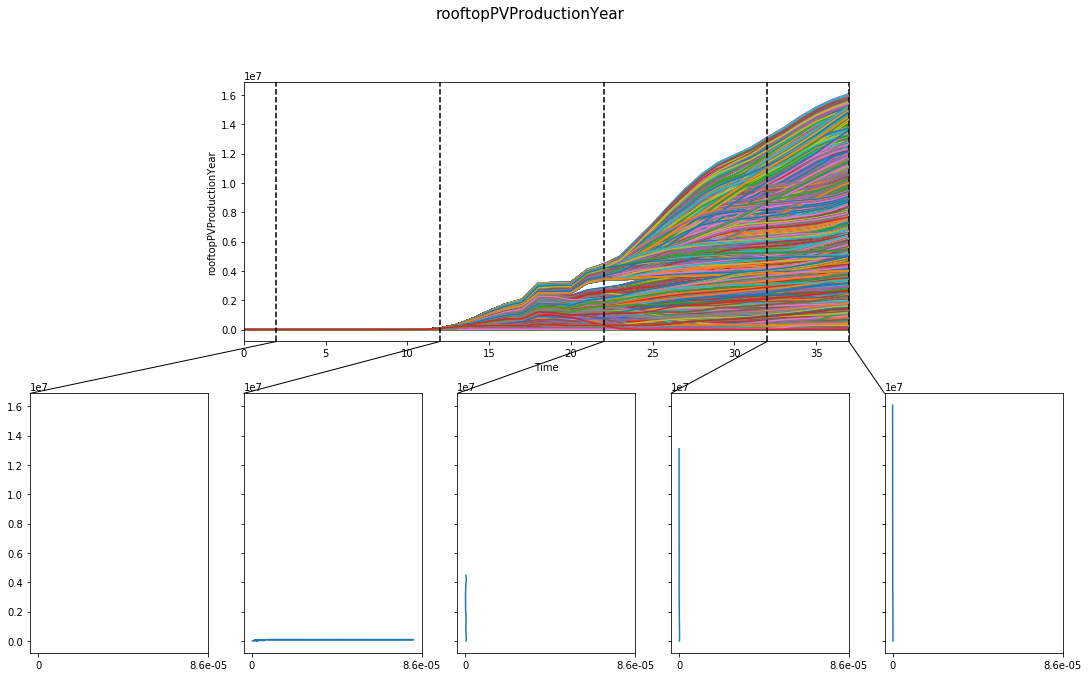

In [96]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),5)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [202]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] includePublicallyAnnouncedGen dropped from analysis because only a single category
[MainProcess/INFO] 48300 points remaining, containing 15241 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.16892339544513457, coverage: 0.5353323272751132, density: 1.0 restricted_dimensions: 5


In [203]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.720491
density     0.908497
id                 2
mass        0.250248
mean        0.908497
res_dim            2
Name: 2, dtype: object

                               box 2                        
                                 min        max    qp values
semiScheduleGenSpotMarket  {primary}  {primary}  [0.0, -1.0]
nonScheduleGenSpotMarket   {primary}  {primary}  [0.0, -1.0]



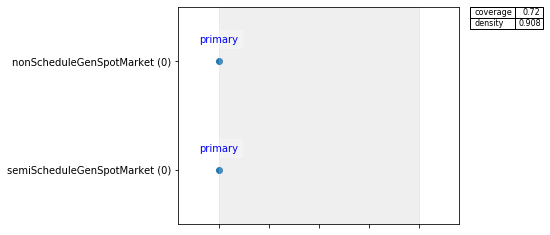

In [204]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

semiScheduleGenSpotMarket ['primary', 'secondary']
nonScheduleGenSpotMarket ['primary', 'secondary']


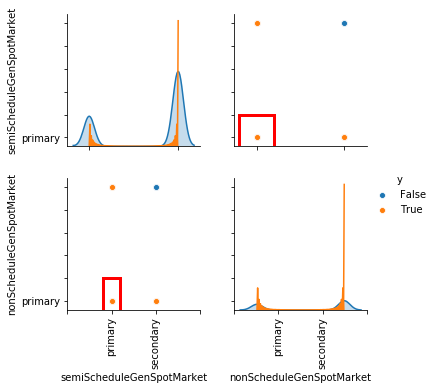

In [205]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()